<a href="https://colab.research.google.com/github/MahdiYousefiIRN/Forcasting/blob/main/NetMachinLearningFinal_ByAttention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


ارایه دهنده مهدی یوسفی
دانشجوی رشته  معماری سیستم های کامپیوتری مقطع کارشناسی ارشد دانشگاه فردوسی مشهد




تعریف مساله:مساله اصلی از نوع پیش بینی مصرف انرژی برق توسط مشترکین برق بر اساس داده های جمع اوری شده یو سی آی  می باشد که ادرس ان در در زیر آورده شده است
دراین مدل های رایه شده پیش بینی مبتنی بر یادگیری عمیق و الگو ومعماری لایه های مختلف
 را با هم مقایسه میکند و بهتریت الگو را با راندمان بهتر را ازایه  می دهد.

UCI :https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,Conv1D,MaxPooling1D
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import Dropout
from keras.layers import Bidirectional,GRU, Embedding,Activation
import pandas as pd
from pandas import read_csv
from pandas import to_numeric
import numpy as np
from numpy import nan
from numpy import isnan
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import math
from google.colab import data_table
from vega_datasets import data
from keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten


ایجاد اتصال به گوگل درایو

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


*بارگذاری* دیتا ست UCI
در اینجا به جای داده های
 null مقدار nan می گذاریم

In [2]:
import pandas as pd  # وارد کردن پکیج pandas برای استفاده از DataFrame و توابع آن

# بارگذاری داده‌ها
df = pd.read_csv(
    '/content/drive/MyDrive/masterthesis_data/household_power_consumption.txt',
    sep=';',
    header=0,
    low_memory=False,
    infer_datetime_format=True,
    parse_dates={'datetime': [0, 1]},
    index_col='datetime'
)

<ipython-input-2-ecfc0a8eb8b4>:4: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(
<ipython-input-2-ecfc0a8eb8b4>:4: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(
<ipython-input-2-ecfc0a8eb8b4>:4: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(


توضیحات:
نمایش مقادیر گمشده: تعداد مقادیر گمشده در هر ستون را چاپ می‌کند.
کپی داده‌ها: یک نسخه کپی از df ایجاد می‌شود.
حذف مقادیر گمشده (اختیاری): می‌توانید ردیف‌هایی که مقادیر گمشده دارند را حذف کنید (خط مربوطه کامنت است).
جایگزینی مقادیر گمشده با میانگین: مقادیر گمشده با میانگین هر ستون پر می‌شود.
جایگزینی مقادیر گمشده با میانه: مقادیر گمشده با میانه هر ستون پر می‌شود.
این کد به‌طور خلاصه داده‌ها را بررسی کرده، سپس مقادیر گمشده را با میانگین یا میانه جایگزین می‌کند.

In [ ]:
print("Before_DF_IsNull =", df.isnull().sum())  # نمایش مقادیر گمشده در هر ستون
datacopy = df.copy()  # کپی از داده‌ها
print("Before Drop Datacopy =", datacopy.shape)  # ابعاد قبل از حذف یا جایگزینی

# حذف ردیف‌های با مقادیر گمشده (اختیاری)
# datacopy.dropna(inplace=True)

# جایگزینی مقادیر گمشده با میانگین هر ستون
datacopy.fillna(datacopy.mean(), inplace=True)
print("After Fill with Mean Datacopy =", datacopy.shape)

# جایگزینی مقادیر گمشده با میانه هر ستون
datacopy.fillna(datacopy.median(), inplace=True)
print("After Fill with Median Datacopy =", datacopy.shape)


Before_DF_IsNull = Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64
Before Drop Datacopy = (2075259, 7)


به‌طور خلاصه:
کد  برای آماده‌سازی و نمایش داده‌ها استفاده می‌شود:

مقادیر گمشده ('?') را با NaN جایگزین می‌کند.
تمامی مقادیر غیر عددی را به NaN تبدیل کرده و داده‌ها را به نوع عددی (float32) تبدیل می‌کند.
مقادیر گمشده را با میانگین هر ستون پر می‌کند.
نوع داده‌ها را بهینه می‌کند تا مصرف حافظه کاهش یابد.
داده‌ها را در یک جدول تعاملی به صورت صفحه‌بندی شده نمایش می‌دهد.

In [18]:
import pandas as pd
import numpy as np  # وارد کردن پکیج numpy برای استفاده از np.nan و توابع آن

# جایگزینی مقادیر گمشده ('?') با NaN
df.replace('?', np.nan, inplace=True)

# تبدیل ستون‌های غیر عددی به مقدار عددی (float32)
df = df.apply(pd.to_numeric, errors='coerce')

# مدیریت داده‌های گمشده
# روش‌های مختلف برای پر کردن مقادیر گمشده، اینجا از پر کردن با میانگین استفاده شده است.
df.fillna(df.mean(), inplace=True)

# بهینه‌سازی نوع داده‌ها به float32 برای کاهش مصرف حافظه
df = df.astype('float32')
# نمایش داده‌ها به صورت تعاملی
df


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.839996,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.630005,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.289993,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.740005,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.679993,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.429993,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.000,240.000000,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.000,239.820007,3.8,0.0,0.0,0.0


Support for third party widgets will remain active for the duration of the session. To disable support:

In [19]:
df.shape
df.info()
df.head(4)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float32
 1   Global_reactive_power  float32
 2   Voltage                float32
 3   Global_intensity       float32
 4   Sub_metering_1         float32
 5   Sub_metering_2         float32
 6   Sub_metering_3         float32
dtypes: float32(7)
memory usage: 71.2 MB


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.839996,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.630005,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.289993,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.740005,23.0,0.0,1.0,17.0




```
# This is formatted as code
```





> Add blockquote


توضیحات خلاصه:
تعریف یک روز به دقیقه:

one_day = 60 * 24 تعداد دقیقه‌های یک روز را محاسبه می‌کند (1440 دقیقه).
پیمایش تمام ردیف‌ها و ستون‌ها:

با استفاده از دو حلقه for به تمام ردیف‌ها و ستون‌های آرایه (values) دسترسی پیدا می‌کنیم.
بررسی مقادیر گمشده (NaN):

در هر موقعیت، با np.isnan بررسی می‌کنیم که آیا مقدار در موقعیت (row, col) برابر با NaN است یا نه.
جایگزینی مقادیر گمشده:

اگر مقدار گمشده باشد، آن را با مقدار مشابه از 1440 دقیقه (یک روز) پیش پر می‌کنیم.
قبل از انجام این کار، اطمینان می‌یابیم که ردیف قبلی (row - one_day) وجود دارد.
برگرداندن داده‌ها:

پس از انجام تغییرات، آرایه اصلاح‌شده را برمی‌گردانیم.
نکات مهم:
وارد کردن numpy: تابع isnan از پکیج numpy برای شناسایی مقادیر گمشده استفاده می‌شود.
محدودیت بررسی: با استفاده از شرط if row - one_day >= 0 اطمینان حاصل می‌کنیم که زمانی که می‌خواهیم مقدار را از یک روز پیش جایگزین کنیم، ردیف مورد نظر در دسترس باشد.
این کد به‌طور کلی برای پر کردن مقادیر گمشده (NaN) در داده‌هایی که به‌صورت زمانی مرتب شده‌اند (مثلاً داده‌های دقیقه‌ای) از مقادیر مشابه در 24 ساعت گذشته استفاده می‌کند.

In [21]:
import numpy as np  # برای استفاده از isnan

def fill_missing(values):
    one_day = 60 * 24  # تعداد دقیقه‌های یک روز
    for row in range(values.shape[0]):  # پیمایش ردیف‌ها
        for col in range(values.shape[1]):  # پیمایش ستون‌ها
            if np.isnan(values[row, col]):  # بررسی مقدار گمشده (NaN)
                if row - one_day >= 0:  # اطمینان از اینکه ردیف قبلی وجود دارد
                    values[row, col] = values[row - one_day, col]  # جایگزینی با مقدار همان ستون در 24 ساعت پیش
    return values  # برگرداندن آرایه اصلاح‌شده



اعمال missing value

در کد شما تابع fill_missing(df.values) برای پر کردن مقادیر گمشده (NaN) استفاده شده و سپس تعداد مقادیر گمشده باقی‌مانده در DataFrame با df.isnull().sum() چاپ می‌شود. با این حال، توجه داشته باشید که df.values فقط مقادیر داخلی DataFrame را به صورت یک numpy array برمی‌گرداند، و بنابراین پس از اعمال تغییرات، این تغییرات در df اعمال نمی‌شود. باید از df.values به درستی استفاده کنید یا مستقیماً DataFrame را به تابع ارسال کنید.

In [23]:
# پر کردن مقادیر گمشده
fill_missing(df.values)

# نمایش تعداد مقادیر گمشده باقی‌مانده در DataFrame
print("DF_IsNull =", df.isnull().sum())


DF_IsNull = Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


نمونه برداری به صورت  دقیقه ای

نمونه برداری از داده ها به صورت ساعتی

توضیح کوتاه عملکرد کد:
تجمیع داده‌ها به صورت ساعتی (df.resample('H').sum()):

داده‌ها بر اساس زمان (که در index DataFrame قرار دارد) به ساعاتی تجمیع می‌شوند و مجموع مقدار Global_active_power در هر ساعت محاسبه می‌شود.
انتخاب داده‌های خاص (df_resampled['Global_active_power'][7:32]):

از داده‌های ساعتی استخراج‌شده، فقط مقادیر از ردیف 7 تا 31 (معمولاً بازه زمانی خاصی از روز) انتخاب می‌شود.
رسم نمودار:

داده‌های انتخاب‌شده برای مصرف توان Global Active Power به صورت یک نمودار خطی نمایش داده می‌شود.
عنوان، برچسب‌ها و افسانه (legend) به نمودار اضافه می‌شود و نمودار با شبکه (grid) رسم می‌شود.
در نهایت، این کد مصرف توان فعال جهانی را به صورت ساعتی برای یک بازه زمانی خاص (ردیف‌های 7 تا 31) نشان می‌دهد.

<ipython-input-31-3ab96c190696>:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df.resample('H').sum()  # تجمیع داده‌ها بر اساس ساعت
<ipython-input-31-3ab96c190696>:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  daily_data_H = df.resample('H').sum()  # مجموع داده‌ها در هر ساعت


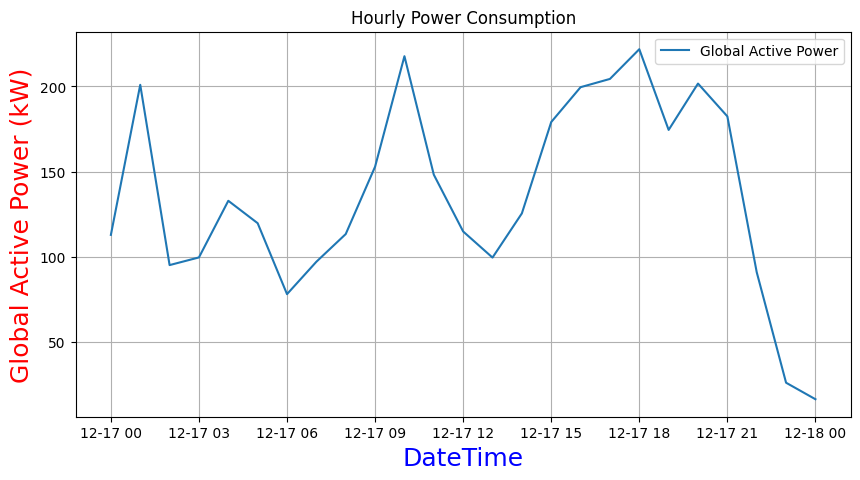

In [31]:
import matplotlib.pyplot as plt

# تجمیع داده‌ها به صورت ساعتی
df_resampled = df.resample('H').sum()  # تجمیع داده‌ها بر اساس ساعت

# استخراج داده‌های خاص (محدوده 7 تا 32)
Daily = df_resampled['Global_active_power'][7:32]
# تجمیع داده‌ها به صورت روزانه
daily_data = df.resample('D').sum()  # مجموع داده‌ها در هر روز
# تجمیع داده‌ها به صورت ساعتی
daily_data_H = df.resample('H').sum()  # مجموع داده‌ها در هر ساعت
# رسم نمودار
plt.figure(figsize=(10, 5))
plt.title("Hourly Power Consumption")
plt.plot(Daily)
plt.xlabel('DateTime', fontsize=18, color='blue')
plt.ylabel('Global Active Power (kW)', fontsize=18, color='red')
plt.legend(['Global Active Power'], loc='upper right')
plt.grid(True)
plt.show()


به منظور رسم نمودار مصرف توان فعال جهانی (Global Active Power) به صورت ساعتی برای یک بازه زمانی از تاریخ‌های مشخص (2006/12/16 تا 2010/11/26) طراحی شده است

<ipython-input-27-fe9b11546663>:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  daily_data_H = df.resample('H').sum()  # مجموع داده‌ها در هر ساعت


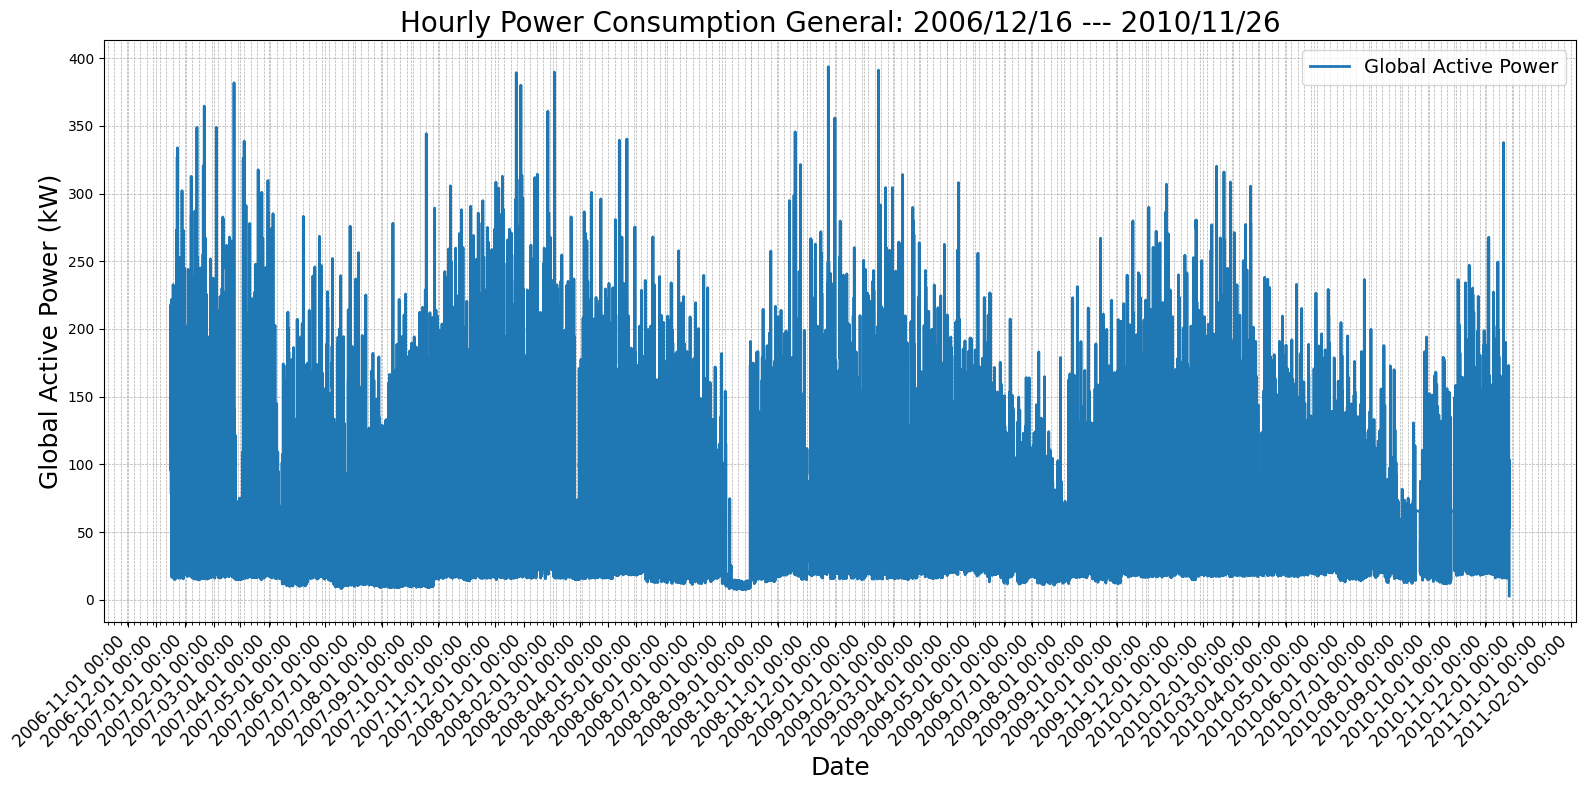

In [27]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# رسم نمودار
plt.figure(figsize=(16, 8))

# عنوان نمودار
plt.title("Hourly Power Consumption General: 2006/12/16 --- 2010/11/26", fontsize=20)

# رسم داده‌ها
plt.plot(daily_data_H['Global_active_power'], color='tab:blue', linewidth=2, label='Global Active Power')

# تنظیمات محور X (تاریخ)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Global Active Power (kW)', fontsize=18)

# تنظیم فرمت تاریخ در محور X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # هر ماه یک تیک
plt.gca().xaxis.set_minor_locator(mdates.WeekdayLocator())  # هر هفته یک تیک

# چرخش تاریخ‌ها برای خوانایی بهتر
plt.xticks(rotation=45, ha='right', fontsize=12)

# تنظیم خطوط مشبک
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# افزودن افسانه (Legend)
plt.legend(loc='upper right', fontsize=14)

# افزودن تگ‌های داده (اختیاری)
# برای مثال، اولین و آخرین نقطه را مشخص می‌کنیم
plt.annotate(f'{daily_data_H["Global_active_power"].iloc[0]:.2f} kW',
             xy=(0, daily_data_H["Global_active_power"].iloc[0]),
             xytext=(0, daily_data_H["Global_active_power"].iloc[0] + 1),
             arrowprops=dict(facecolor='red', shrink=0.05),
             fontsize=12, color='black')

plt.annotate(f'{daily_data_H["Global_active_power"].iloc[-1]:.2f} kW',
             xy=(len(daily_data_H) - 1, daily_data_H["Global_active_power"].iloc[-1]),
             xytext=(len(daily_data_H) - 10, daily_data_H["Global_active_power"].iloc[-1] - 1),
             arrowprops=dict(facecolor='red', shrink=0.05),
             fontsize=12, color='black')

# نمایش نمودار
plt.tight_layout()  # برای جلوگیری از برش عنوان‌ها
plt.show()


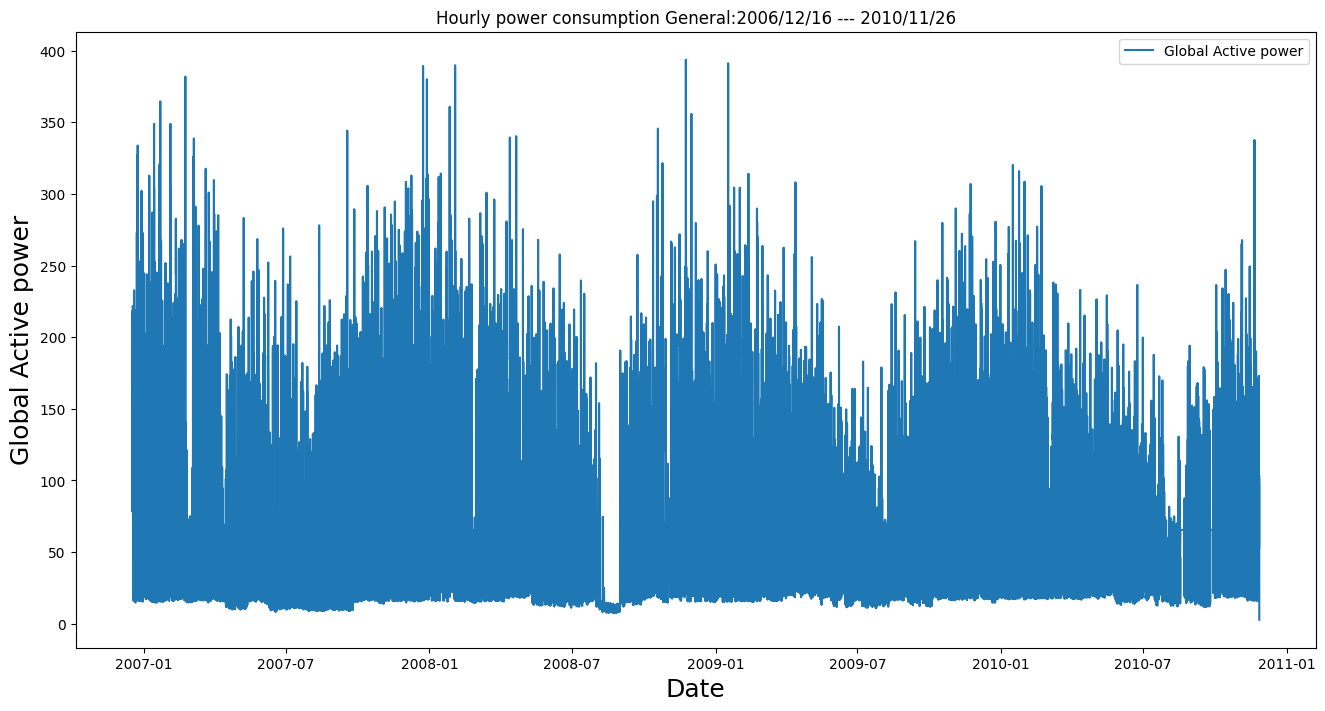

In [34]:
plt.figure(figsize=(16,8))
plt.title("Hourly power consumption General:2006/12/16 --- 2010/11/26")
plt.plot(daily_data_H['Global_active_power'])
plt.xlabel('Date',fontsize = 18 )
plt.ylabel('Global Active power',fontsize = 18 )
plt.legend(['Global Active power', 'Global Active power'], loc='upper right')
plt.show()

In [35]:
daily_groups = df.resample('D')
daily_data = daily_groups.sum()
daily_data


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16,1209.176025,34.922001,93552.53125,5180.799805,0.0,546.0,4926.0
2006-12-17,3390.459961,226.005997,345725.31250,14398.599609,2033.0,4187.0,13341.0
2006-12-18,2203.825928,161.792007,347373.62500,9247.200195,1063.0,2621.0,14018.0
2006-12-19,1666.193970,150.942001,348479.00000,7094.000000,839.0,7602.0,6197.0
2006-12-20,2225.748047,160.998001,348923.62500,9313.000000,0.0,2648.0,14063.0
...,...,...,...,...,...,...,...
2010-11-22,2041.536011,142.354004,345883.84375,8660.400391,4855.0,2110.0,10136.0
2010-11-23,1577.536011,137.449997,346428.75000,6731.200195,1871.0,458.0,7611.0
2010-11-24,1796.248047,132.460007,345644.59375,7559.399902,1096.0,2848.0,12224.0


نمودار  مصرف برق مشترکین  به صورت روزانه

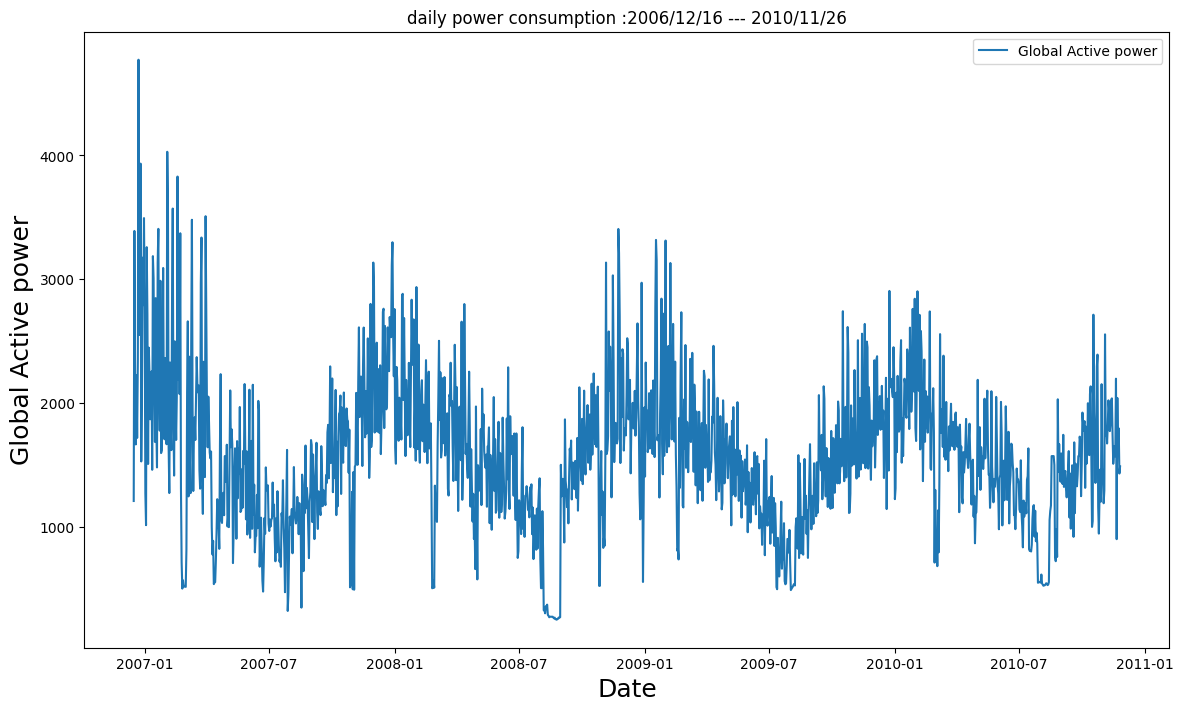

In [36]:
plt.figure(figsize=(14,8))
plt.title("daily power consumption :2006/12/16 --- 2010/11/26")
plt.plot(daily_data['Global_active_power'])
plt.xlabel('Date',fontsize = 18 )
plt.ylabel('Global Active power',fontsize = 18 )
plt.legend(['Global Active power', 'Global Active power'], loc='upper right')
plt.show()

نمایش داده ها به صورت ساعتی

#  
 جدا کردن داده های تست و روزانه
 را می توان توسط توابع کتابخانه ای مثل skitLearn از هم جدا کرد

In [38]:
from sklearn.model_selection import train_test_split

# تقسیم داده‌ها به مجموعه‌های آموزشی و تست
train_data, test_data = train_test_split(daily_data, test_size=0.3, train_size=0.7, shuffle=False)

# نمایش اندازه داده‌ها
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")


Train data shape: (1009, 7)
Test data shape: (433, 7)


In [ ]:
train_size = int(len(daily_data) * 0.80)
test_size = len(daily_data) - train_size
train, test = daily_data.iloc[0:train_size], daily_data.iloc[train_size:len(daily_data)]
print("train : ",len(train)," -------  test : " ,len(test))

print("*******************************")
print( train)
print("*******************************")
print( test)
print("*******************************")








train :  1153  -------  test :  289
*******************************
            Global_active_power  Global_reactive_power       Voltage  \
datetime                                                               
2006-12-16          1209.176025              34.922001   93552.53125   
2006-12-17          3390.459961             226.005997  345725.31250   
2006-12-18          2203.825928             161.792007  347373.62500   
2006-12-19          1666.193970             150.942001  348479.00000   
2006-12-20          2225.748047             160.998001  348923.62500   
...                         ...                    ...           ...   
2010-02-06          2712.986084             296.614014  347172.59375   
2010-02-07          1625.708008             162.466003  349465.62500   
2010-02-08          2582.238037             139.750000  348475.37500   
2010-02-09          2420.931885             139.712006  350136.53125   
2010-02-10          1946.878052             141.621994  349124.37500

train , test

*نرمال* سازی داده ها بین مقادیر صفر تا یک  با تابع مین مکس اسکیلر وبا استفاده  از کتابخانه
سایکیت لرن

In [ ]:
from sklearn.preprocessing import MinMaxScaler
f_columns = ['Global_reactive_power',	'Voltage',	'Global_intensity',	'Sub_metering_1',	'Sub_metering_2',	'Sub_metering_3']
f_transformer = MinMaxScaler()
f_transformer = f_transformer.fit(train[f_columns].to_numpy())
print(f_transformer)

MinMaxScaler()


In [ ]:
train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
test.loc[:, f_columns]   = f_transformer.transform(test[f_columns].to_numpy())

<ipython-input-16-d62520055812>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
<ipython-input-16-d62520055812>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, f_columns]   = f_transformer.transform(test[f_columns].to_numpy())


In [ ]:
cnt_transformer = MinMaxScaler()
cnt_transformer = cnt_transformer.fit(train[['Global_active_power']])
train['Global_active_power'] = cnt_transformer.transform(train[['Global_active_power']])
test['Global_active_power'] = cnt_transformer.transform(test[['Global_active_power']])
print("****************************************")
print("trainMax=",train['Global_active_power'].max)
print("trainMin=",train['Global_active_power'].min)
print("****************************************")
train['Global_active_power'].max
train['Global_active_power'].min

****************************************
trainMax= <bound method NDFrame._add_numeric_operations.<locals>.max of datetime
2006-12-16    0.211996
2006-12-17    0.694252
2006-12-18    0.431901
2006-12-19    0.313037
2006-12-20    0.436748
                ...   
2010-02-06    0.544470
2010-02-07    0.304086
2010-02-08    0.515564
2010-02-09    0.479901
2010-02-10    0.375093
Freq: D, Name: Global_active_power, Length: 1153, dtype: float32>
trainMin= <bound method NDFrame._add_numeric_operations.<locals>.min of datetime
2006-12-16    0.211996
2006-12-17    0.694252
2006-12-18    0.431901
2006-12-19    0.313037
2006-12-20    0.436748
                ...   
2010-02-06    0.544470
2010-02-07    0.304086
2010-02-08    0.515564
2010-02-09    0.479901
2010-02-10    0.375093
Freq: D, Name: Global_active_power, Length: 1153, dtype: float32>
****************************************


<ipython-input-17-4c93b573a276>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Global_active_power'] = cnt_transformer.transform(train[['Global_active_power']])
<ipython-input-17-4c93b573a276>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Global_active_power'] = cnt_transformer.transform(test[['Global_active_power']])


<bound method NDFrame._add_numeric_operations.<locals>.min of datetime
2006-12-16    0.211996
2006-12-17    0.694252
2006-12-18    0.431901
2006-12-19    0.313037
2006-12-20    0.436748
                ...   
2010-02-06    0.544470
2010-02-07    0.304086
2010-02-08    0.515564
2010-02-09    0.479901
2010-02-10    0.375093
Freq: D, Name: Global_active_power, Length: 1153, dtype: float32>

create Dataset

In [ ]:
def create_dataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps),1:].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps:i + time_steps+1])
    return np.array(Xs), np.array(ys)

In [ ]:

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    print(df['date'])
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear

    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]

description

در اینجا داده های مقادیر روزانه را به دوقسمت داده های تست و اموزش به صورت سه روزی به متد ساخت ارایه از روی دیتا ست میدهیم تا ابعاد ارایه را مشخص کند

In [ ]:
time_steps = 3
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train, train.Global_active_power, time_steps)
X_test, y_test = create_dataset(test, test.Global_active_power, time_steps)
print("**********************************************************")
print("X_train = ",X_train.shape," --------- y_train = ", y_train.shape)

print("**********************************************************")
print("X_test =",X_test.shape," ---------  y_test = ", y_test.shape)
print("**********************************************************")
print(X_train)


**********************************************************
X_train =  (1150, 3, 7)  --------- y_train =  (1150, 1)
**********************************************************
X_test = (286, 3, 7)  ---------  y_test =  (286, 1)
**********************************************************
[[[0.21199632 0.         0.         ... 0.         0.04509043 0.1620129 ]
  [0.6942517  0.49902847 0.9597301  ... 0.18187511 0.34577587 0.5367624 ]
  [0.43190134 0.33132938 0.96600324 ... 0.09509751 0.21645057 0.5669116 ]]

 [[0.6942517  0.49902847 0.9597301  ... 0.18187511 0.34577587 0.5367624 ]
  [0.43190134 0.33132938 0.96600324 ... 0.09509751 0.21645057 0.5669116 ]
  [0.31303743 0.3029939  0.97021013 ... 0.07505815 0.6277975  0.218615  ]]

 [[0.43190134 0.33132938 0.96600324 ... 0.09509751 0.21645057 0.5669116 ]
  [0.31303743 0.3029939  0.97021013 ... 0.07505815 0.6277975  0.218615  ]
  [0.43674806 0.3292558  0.9719023  ... 0.         0.21868032 0.5689156 ]]

 ...

 [[0.40870175 0.28219536 0.96989197 .

مدل ارایه شده

مقادیری که حاوی داده های لایه  Embedding

In [ ]:
# Embedding
max_features = 20000
maxlen = 100
embedding_size = 128

# Convolution
kernel_size = 2
filters = 128
pool_size = 2

# LSTM
lstm_output_size = 128

# Training
batch_size = 128
epochs = 100

مدل اول مورد بررسی  ترکیب لایه های
CNN
Bidirectional -LSTM



In [ ]:
model_CNN_BI_LSTM = Sequential()
model_CNN_BI_LSTM.add(Conv1D(filters,kernel_size, padding='valid',activation='relu',
                 strides=1))
model_CNN_BI_LSTM.add(MaxPooling1D(pool_size=pool_size))
model_CNN_BI_LSTM.add(Bidirectional(LSTM(lstm_output_size, activation='relu',return_sequences=True)))
model_CNN_BI_LSTM.add(Bidirectional(LSTM(lstm_output_size, activation='relu',return_sequences=True)))
model_CNN_BI_LSTM.add(LSTM(lstm_output_size, activation='relu', return_sequences=False))
model_CNN_BI_LSTM.add(RepeatVector(7))
model_CNN_BI_LSTM.add(LSTM(128, activation='relu', return_sequences=True))
model_CNN_BI_LSTM.add(LSTM(lstm_output_size, activation='relu', return_sequences=True))
model_CNN_BI_LSTM.add(Dropout(0.25))
model_CNN_BI_LSTM.add(LSTM(lstm_output_size, activation='relu', return_sequences=False))
model_CNN_BI_LSTM.add(Dropout(0.25))
model_CNN_BI_LSTM.add(Flatten())
model_CNN_BI_LSTM.add(Dense(128,activation='relu'))
model_CNN_BI_LSTM.add(Dense( units=1))
opt = keras.optimizers.Adam()
# model_BI_LSTM.compile(loss='mse', optimizer='adam')
model_CNN_BI_LSTM.compile(loss='mse',optimizer=opt, metrics=['mae','mape'])
model_CNN_BI_LSTM.build(input_shape=(None,X_train.shape[1],X_train.shape[2])) # `input_shape` is the shape of the input data
print(model_CNN_BI_LSTM.summary())



Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 2, 128)            1920      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 128)           0         
 1D)                                                             
                                                                 
 bidirectional_2 (Bidirectio  (None, 1, 256)           263168    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 1, 256)           394240    
 nal)                                                            
                                                                 
 lstm_8 (LSTM)               (None, 128)               197120    
                                                     

In [ ]:
import random
import numpy as np
import math
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM, RepeatVector, Dropout, Bidirectional
from deap import base, creator, tools, algorithms


In [ ]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear

    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year',
            'dayofyear', 'dayofmonth', 'weekofyear']]

    return X  # Return the extracted features


In [ ]:
def create_dataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps), :].values  # Extract all columns as features
        Xs.append(v)
        ys.append(y.iloc[i + time_steps:i + time_steps + 1])
    return np.array(Xs), np.array(ys)


In [ ]:
def build_model(num_units, dropout_rate, input_shape, output_shape):
    model = Sequential()
    model.add(Dense(num_units, activation='relu', input_shape=(input_shape,)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(output_shape, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [ ]:
def train_and_evaluate_model(model, data):
    X_train, y_train, X_val, y_val = data
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=0)
    y_pred = model.predict(X_val)
    evaluation_metric = mean_squared_error(y_val, y_pred)
    return evaluation_metric


In [ ]:
def evaluate_model(individual):
    num_units = individual[0]
    dropout_rate = individual[1]

    model = build_model(num_units, dropout_rate, X_train.shape[1], y_train.shape[1])
    evaluation_metric = train_and_evaluate_model(model, (X_train, y_train, X_test, y_test))

    return evaluation_metric,


In [ ]:
# !pip install DEAP
from keras.models import Sequential
from keras.layers import Dense, Dropout
import random
from deap import base, creator, tools, algorithms

# input_shape = X_train.shape[1:]
# output_shape = (1,)
num_units = 128
dropout_rate = 0
time_steps = 3  # تعداد گام‌های زمانی در هر نمونه
n_features = 6  # تعداد ویژگی‌ها یا متغیرهای ورودی
input_shape = (time_steps, n_features)  # مطابق با ابعاد داده‌های آموزشی
output_shape = (1,)  # مطابق با تعداد ویژگی‌های خروجی


# Define the build_model function
def build_model(num_units, dropout_rate):
    model = Sequential()
    model.add(LSTM(num_units, activation='relu', input_shape=(input_shape,)))  # Replace input_shape with the actual shape of your input data
    model.add(Dropout(dropout_rate))
    model.add(Dense(output_shape, activation='linear'))  # Replace output_shape with the actual number of output units
    model.compile(optimizer='adam', loss='mean_squared_error')  # You can use a different optimizer and loss function if needed
    return model

# Define the train_and_evaluate_model function
def train_and_evaluate_model(model, data):
    X_train, y_train, X_val, y_val = data  # Split your data into training and validation sets
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=0)
    evaluation_metric = model.evaluate(X_val, y_val, verbose=0)  # You can use a custom evaluation metric here
    return evaluation_metric

# Define the evaluation function using your model and data
def evaluate_model(individual):
    num_units = individual[0]
    dropout_rate = individual[1]
    # Extract other hyperparameters...

    # Build and compile the model using the extracted hyperparameters
    model = build_model(num_units, dropout_rate)  # Implement this function
    # Train the model and evaluate it using your evaluation metric
    evaluation_metric = train_and_evaluate_model(model, data)  # Implement this function

    return evaluation_metric,

# Define the parameter space for optimization
param_space = {
    'units': [64, 128, 256],
    'dropout_rate': [0.2, 0.3, 0.4],
    # Add more hyperparameters and values
}

# Create the DEAP toolbox and register components
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_units", random.choice, param_space['units'])
toolbox.register("attr_dropout", random.choice, param_space['dropout_rate'])

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_units, toolbox.attr_dropout), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate_model)  # Register the evaluate function

# Run the optimization algorithm
population = toolbox.population(n=10)
algorithms.eaMuPlusLambda(population, toolbox, mu=10, lambda_=50,
                          cxpb=0.7, mutpb=0.2, ngen=10, verbose=True)


/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


TypeError: ignored

In [ ]:
# Create an example individual with specific values for num_units and dropout_rate
example_individual = [128, 0.3]  # num_units = 128, dropout_rate = 0.3

# Pass the example individual to the evaluate_model function
evaluation_result = evaluate_model(example_individual)
print("Evaluation result:", evaluation_result)


TypeError: ignored

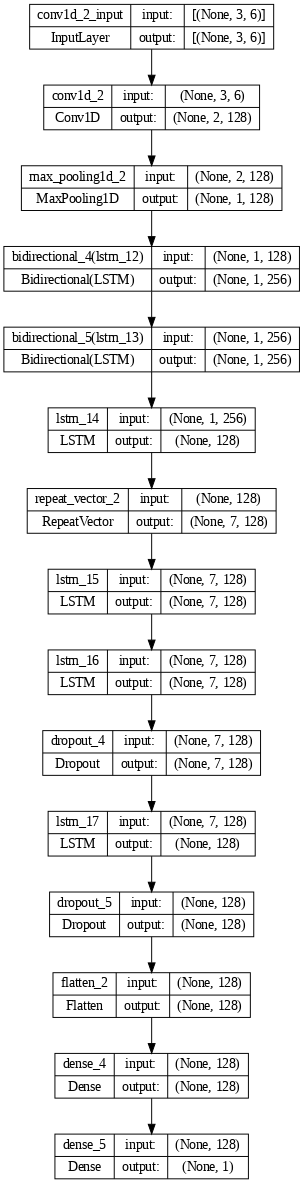

In [ ]:
keras.utils.plot_model(model_CNN_BI_LSTM, show_shapes=True, dpi = 70)

In [ ]:
print('ُStart Training ...')
history = model_CNN_BI_LSTM.fit(X_train, y_train, epochs=100, batch_size=128, validation_split=0.3)
# history = model_CNN_BI_LSTM.fit(X_train, y_train, epochs=100, batch_size=128, validation_split=0.3)


ُStart Training ...
Epoch 1/100
7/7 [==============================] - 18s 366ms/step - loss: 0.0936 - mae: 0.2681 - mape: 100527.2188 - val_loss: 0.0397 - val_mae: 0.1708 - val_mape: 55.3704
Epoch 2/100
7/7 [==============================] - 1s 142ms/step - loss: 0.0338 - mae: 0.1410 - mape: 465060.0938 - val_loss: 0.0293 - val_mae: 0.1455 - val_mape: 84.9347
Epoch 3/100
7/7 [==============================] - 1s 142ms/step - loss: 0.0285 - mae: 0.1353 - mape: 398525.9688 - val_loss: 0.0124 - val_mae: 0.0888 - val_mape: 45.1509
Epoch 4/100
7/7 [==============================] - 1s 146ms/step - loss: 0.0245 - mae: 0.1192 - mape: 323114.6250 - val_loss: 0.0135 - val_mae: 0.0919 - val_mape: 41.9122
Epoch 5/100
7/7 [==============================] - 1s 143ms/step - loss: 0.0233 - mae: 0.1160 - mape: 285310.8125 - val_loss: 0.0127 - val_mae: 0.0914 - val_mape: 50.0747
Epoch 6/100
7/7 [==============================] - 1s 137ms/step - loss: 0.0226 - mae: 0.1157 - mape: 374973.6250 - val_loss

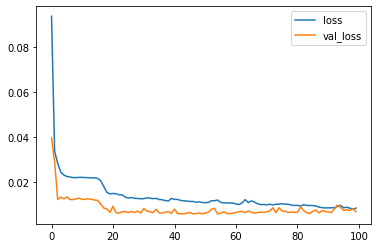

In [ ]:
plt.plot(history.history['loss'] , label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

In [ ]:
y_pred = model_CNN_BI_LSTM.predict(x_train)
print('y_train=',y_train)
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1,-1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1,-1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred.reshape(1,-1))

print(y_test_inv.shape)
print(y_pred_inv.shape)

testScore = math.sqrt(mean_squared_error(y_test, y_pred))
MAPE=mean_absolute_percentage_error(y_test, y_pred)
MAE =mean_absolute_error(y_test, y_pred)
print('******  model_CNN_BI_LSTM  ********')
print('Test Score: %.2f RMSE' % (testScore))
print('Test Score: %.2f MAPE' % (MAPE))
print('Test Score: %.2f MAE' % (MAE))

9/9 [==============================] - 1s 29ms/step
y_train= [[0.31303743]
 [0.43674806]
 [0.32566023]
 ...
 [0.51556367]
 [0.47990084]
 [0.37509328]]
(1, 286)
(1, 286)
******  model_CNN_BI_LSTM  ********
Test Score: 0.08 RMSE
Test Score: 0.26 MAPE
Test Score: 0.06 MAE


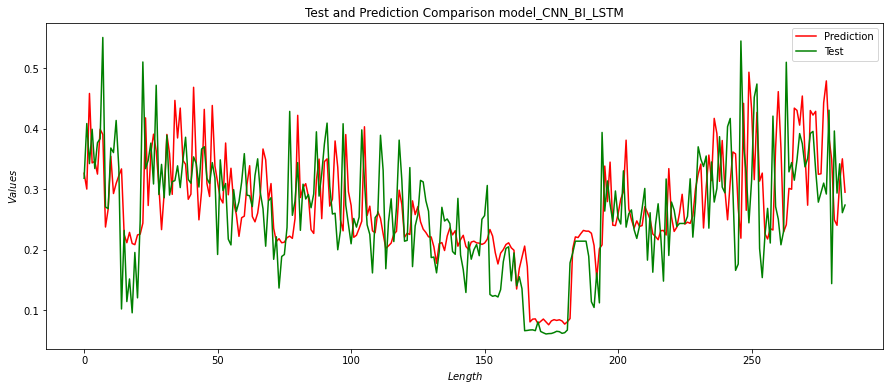

In [ ]:
ax=plt.figure(figsize=(15,6))
plt.ylabel('$Values$')
plt.xlabel('$Length$')
plt.title("Test and Prediction Comparison model_CNN_BI_LSTM")
plt.plot(y_pred , label='pred',color='red')
plt.plot(y_test , label='pred',color='green')
plt.legend(['Prediction', 'Test'], loc='upper right')
plt.show()

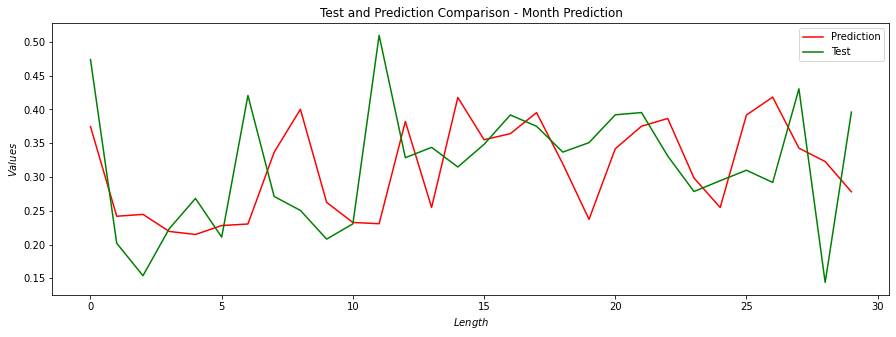

In [ ]:
MonthRealData=y_test[252:282]
MonthPrediction=y_pred[252:282]
ax=plt.figure(figsize=(15,5))
plt.ylabel('$Values$')
plt.xlabel('$Length$')
plt.title("Test and Prediction Comparison - Month Prediction")
plt.plot(MonthPrediction , label='pred',color='red')
plt.plot(MonthRealData , label='pred',color='green')
plt.legend(['Prediction', 'Test'], loc='upper right')
plt.show()

Model BI_GRU

In [ ]:
model_BI_GRU = Sequential()
model_BI_GRU.add(Bidirectional(GRU(128, activation='relu',return_sequences=True)))
model_BI_GRU.add(Bidirectional(GRU(128, activation='relu',return_sequences=True)))
model_BI_GRU.add(GRU(128, activation='relu', return_sequences=True))
model_BI_GRU.add(Dropout(0.25))
model_BI_GRU.add(GRU(128, activation='relu', return_sequences=True))
model_BI_GRU.add(Dropout(0.25))
model_BI_GRU.add(GRU(128, activation='relu', return_sequences=False))
model_BI_GRU.add(Dropout(0.25))
model_BI_GRU.add(Flatten())
model_BI_GRU.add(Dense(128,activation='relu'))
model_BI_GRU.add(Dense( units=1))
# opt = keras.optimizers.Adam(learning_rate=0.001)
model_BI_GRU.compile(loss='mse', optimizer='adam')
model_BI_GRU.build(input_shape=(None,X_train.shape[1],X_train.shape[2])) # `input_shape` is the shape of the input data                         # e.g. input_shape = (None, 32, 32, 3)
model_BI_GRU.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_9 (Bidirectio  (None, 3, 256)           104448    
 nal)                                                            
                                                                 
 bidirectional_10 (Bidirecti  (None, 3, 256)           296448    
 onal)                                                           
                                                                 
 gru_7 (GRU)                 (None, 3, 128)            148224    
                                                                 
 dropout_13 (Dropout)        (None, 3, 128)            0         
                                                                 
 gru_8 (GRU)                 (None, 3, 128)            99072     
                                                                 
 dropout_14 (Dropout)        (None, 3, 128)           

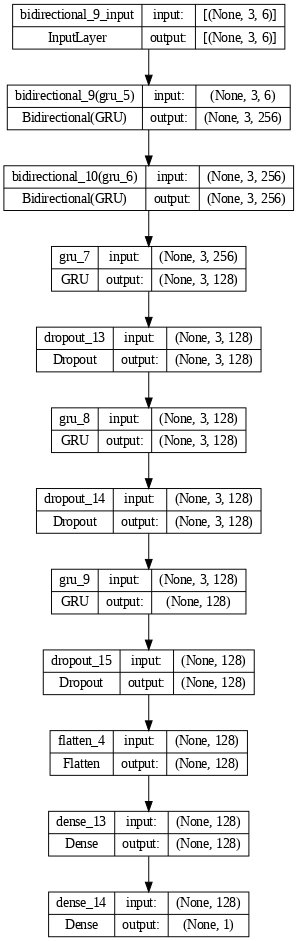

In [ ]:
keras.utils.plot_model(model_BI_GRU, show_shapes=True, dpi = 70)

In [ ]:
history = model_BI_GRU.fit(X_train, y_train, epochs=100, batch_size=128, validation_split=0.3)

Epoch 1/100
7/7 [==============================] - 15s 250ms/step - loss: 0.0667 - val_loss: 0.0304
Epoch 2/100
7/7 [==============================] - 1s 75ms/step - loss: 0.0300 - val_loss: 0.0143
Epoch 3/100
7/7 [==============================] - 1s 84ms/step - loss: 0.0236 - val_loss: 0.0113
Epoch 4/100
7/7 [==============================] - 1s 96ms/step - loss: 0.0220 - val_loss: 0.0115
Epoch 5/100
7/7 [==============================] - 1s 75ms/step - loss: 0.0201 - val_loss: 0.0104
Epoch 6/100
7/7 [==============================] - 1s 77ms/step - loss: 0.0189 - val_loss: 0.0096
Epoch 7/100
7/7 [==============================] - 1s 75ms/step - loss: 0.0179 - val_loss: 0.0082
Epoch 8/100
7/7 [==============================] - 1s 94ms/step - loss: 0.0164 - val_loss: 0.0068
Epoch 9/100
7/7 [==============================] - 1s 169ms/step - loss: 0.0159 - val_loss: 0.0063
Epoch 10/100
7/7 [==============================] - 1s 172ms/step - loss: 0.0150 - val_loss: 0.0063
Epoch 11/100
7/

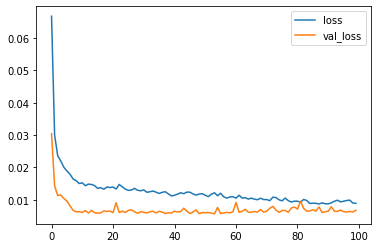

In [ ]:
plt.plot(history.history['loss'] , label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

In [ ]:
y_pred = model_BI_GRU.predict(X_test)
print('y_train=',y_train)
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1,-1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1,-1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred.reshape(1,-1))
print(y_test_inv.shape)
print(y_pred_inv.shape)
testScore = math.sqrt(mean_squared_error(y_test, y_pred))
MAPE=mean_absolute_percentage_error(y_test, y_pred)
MAE =mean_absolute_error(y_test, y_pred)
print('*****  model_BI_GRU  *************' )
print('Test Score: %.2f RMSE' % (testScore))
print('Test Score: %.2f MAPE' % (MAPE))
print('Test Score: %.2f MAE' % (MAE))

9/9 [==============================] - 1s 8ms/step
y_train= [[0.31303743]
 [0.43674806]
 [0.32566023]
 ...
 [0.51556367]
 [0.47990084]
 [0.37509328]]
(1, 286)
(1, 286)
*****  model_BI_GRU  *************
Test Score: 0.08 RMSE
Test Score: 0.32 MAPE
Test Score: 0.06 MAE


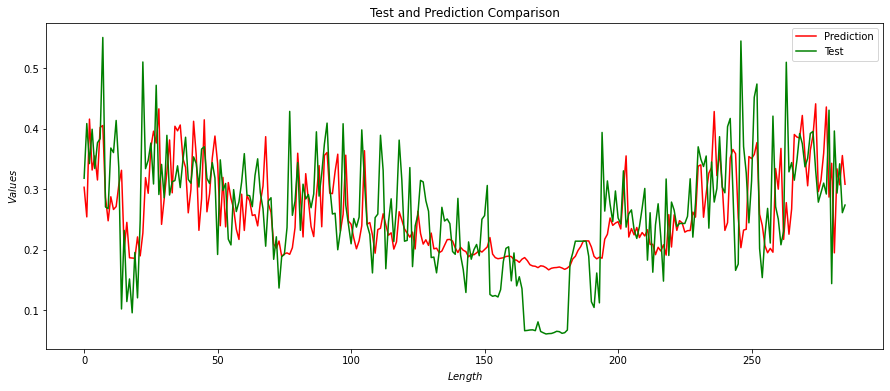

In [ ]:
ax=plt.figure(figsize=(15,6))
plt.ylabel('$Values$')
plt.xlabel('$Length$')
plt.title("Test and Prediction Comparison")
plt.plot(y_pred , label='pred',color='red')
plt.plot(y_test , label='pred',color='green')
plt.legend(['Prediction', 'Test'], loc='upper right')
plt.show()

model BI_LSTM

In [ ]:
model_BI_LSTM = Sequential()
model_BI_LSTM.add(Bidirectional(LSTM(128, activation='relu',return_sequences=True)))
model_BI_LSTM.add(Bidirectional(LSTM(128, activation='relu',return_sequences=True)))
model_BI_LSTM.add(LSTM(128, activation='relu', return_sequences=True))
model_BI_LSTM.add(Dropout(0.25))
model_BI_LSTM.add(LSTM(128, activation='relu', return_sequences=True))
model_BI_LSTM.add(Dropout(0.25))
model_BI_LSTM.add(LSTM(128, activation='relu', return_sequences=False))
model_BI_LSTM.add(Dropout(0.25))
model_BI_LSTM.add(Flatten())
model_BI_LSTM.add(Dense(128,activation='relu'))
model_BI_LSTM.add(Dense( units=1))
# opt = keras.optimizers.Adam(learning_rate=0.001)
model_BI_LSTM.compile(loss='mse', optimizer='adam')
model_BI_LSTM.build(input_shape=(None,X_train.shape[1],X_train.shape[2])) # `input_shape` is the shape of the input data                         # e.g. input_shape = (None, 32, 32, 3)
model_BI_LSTM.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_11 (Bidirecti  (None, 3, 256)           138240    
 onal)                                                           
                                                                 
 bidirectional_12 (Bidirecti  (None, 3, 256)           394240    
 onal)                                                           
                                                                 
 lstm_29 (LSTM)              (None, 3, 128)            197120    
                                                                 
 dropout_16 (Dropout)        (None, 3, 128)            0         
                                                                 
 lstm_30 (LSTM)              (None, 3, 128)            131584    
                                                                 
 dropout_17 (Dropout)        (None, 3, 128)           

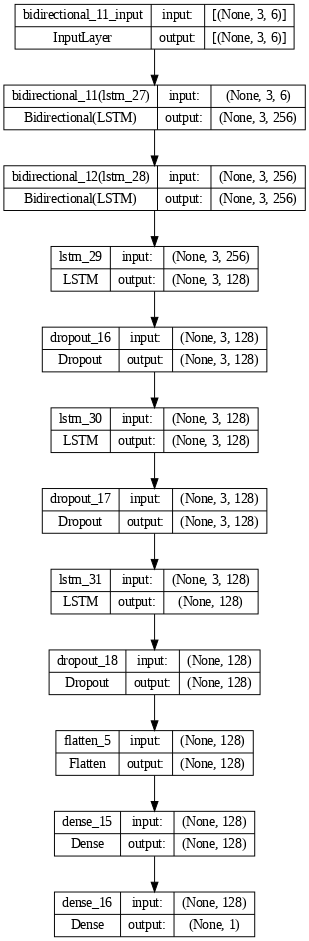

In [ ]:
keras.utils.plot_model(model_BI_LSTM, show_shapes=True, dpi = 70)

In [ ]:
history = model_BI_LSTM.fit(X_train, y_train, epochs=100, batch_size=128, validation_split=0.3)

Epoch 1/100
7/7 [==============================] - 13s 212ms/step - loss: 0.0983 - val_loss: 0.0548
Epoch 2/100
7/7 [==============================] - 0s 60ms/step - loss: 0.0517 - val_loss: 0.0122
Epoch 3/100
7/7 [==============================] - 0s 65ms/step - loss: 0.0263 - val_loss: 0.0152
Epoch 4/100
7/7 [==============================] - 0s 60ms/step - loss: 0.0219 - val_loss: 0.0124
Epoch 5/100
7/7 [==============================] - 0s 65ms/step - loss: 0.0228 - val_loss: 0.0121
Epoch 6/100
7/7 [==============================] - 0s 64ms/step - loss: 0.0218 - val_loss: 0.0130
Epoch 7/100
7/7 [==============================] - 0s 60ms/step - loss: 0.0224 - val_loss: 0.0130
Epoch 8/100
7/7 [==============================] - 0s 58ms/step - loss: 0.0215 - val_loss: 0.0117
Epoch 9/100
7/7 [==============================] - 0s 59ms/step - loss: 0.0211 - val_loss: 0.0114
Epoch 10/100
7/7 [==============================] - 0s 64ms/step - loss: 0.0203 - val_loss: 0.0111
Epoch 11/100
7/7 

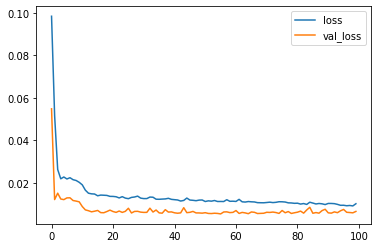

In [ ]:
plt.plot(history.history['loss'] , label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

In [ ]:
y_pred = model_BI_LSTM.predict(X_test)
print('y_train=',y_train)
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1,-1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1,-1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred.reshape(1,-1))
print(y_test_inv.shape)
print(y_pred_inv.shape)
testScore = math.sqrt(mean_squared_error(y_test, y_pred))
MAPE=mean_absolute_percentage_error(y_test, y_pred)
MAE =mean_absolute_error(y_test, y_pred)
print('******* model_BI_LSTM ********************')
print('Test Score: %.2f RMSE' % (testScore))
print('Test Score: %.2f MAPE' % (MAPE))
print('Test Score: %.2f MAE' % (MAE))

9/9 [==============================] - 1s 6ms/step
y_train= [[0.31303743]
 [0.43674806]
 [0.32566023]
 ...
 [0.51556367]
 [0.47990084]
 [0.37509328]]
(1, 286)
(1, 286)
******* model_BI_LSTM ********************
Test Score: 0.08 RMSE
Test Score: 0.23 MAPE
Test Score: 0.06 MAE


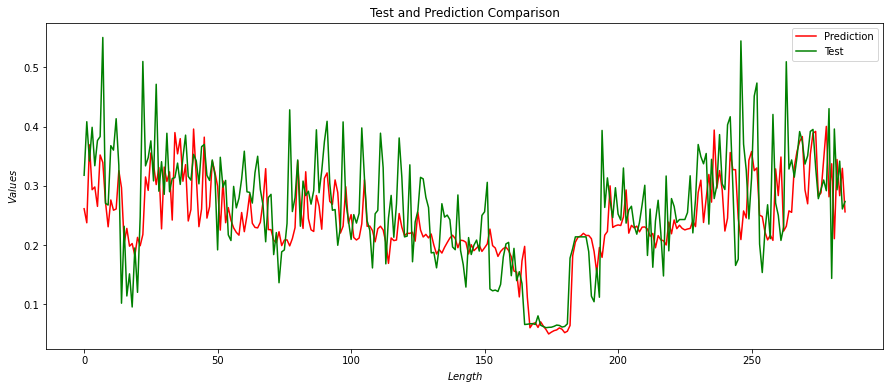

In [ ]:
ax=plt.figure(figsize=(15,6))
plt.ylabel('$Values$')
plt.xlabel('$Length$')
plt.title("Test and Prediction Comparison")
plt.plot(y_pred , label='pred',color='red')
plt.plot(y_test , label='pred',color='green')
plt.legend(['Prediction', 'Test'], loc='upper right')
plt.show()

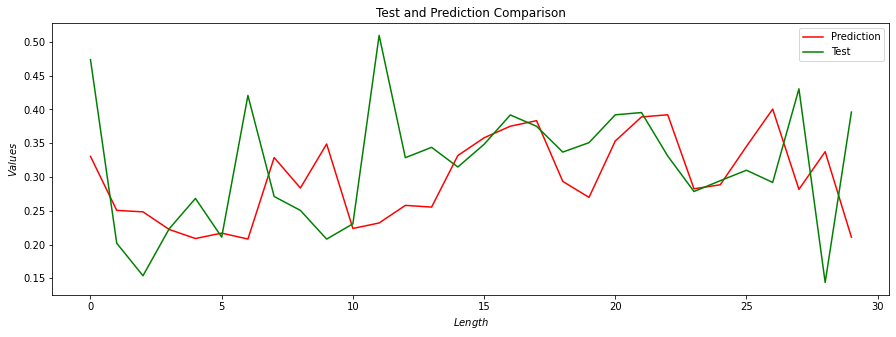

In [ ]:
MonthRealData=y_test[252:282]
MonthPrediction=y_pred[252:282]
ax=plt.figure(figsize=(15,5))
plt.ylabel('$Values$')
plt.xlabel('$Length$')
plt.title("Test and Prediction Comparison")
plt.plot(MonthPrediction , label='pred',color='red')
plt.plot(MonthRealData , label='pred',color='green')
plt.legend(['Prediction', 'Test'], loc='upper right')
plt.show()

Model BI_LSTM_Attenion

In [ ]:
time_steps = 3
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train, train.Global_active_power, time_steps)
X_test, y_test = create_dataset(test, test.Global_active_power, time_steps)
print("**********************************************************")
print("X_train = ",X_train.shape," --------- y_train = ", y_train.shape)

print("**********************************************************")
print("X_test =",X_test.shape," ---------  y_test = ", y_test.shape)
print("**********************************************************")
print(X_train)

**********************************************************
X_train =  (1150, 3, 6)  --------- y_train =  (1150, 1)
**********************************************************
X_test = (286, 3, 6)  ---------  y_test =  (286, 1)
**********************************************************
[[[0.         0.         0.21100625 0.         0.04509043 0.1620129 ]
  [0.49902847 0.9597301  0.69522595 0.18187511 0.34577587 0.5367624 ]
  [0.33132938 0.96600324 0.4246181  0.09509751 0.21645057 0.5669116 ]]

 [[0.49902847 0.9597301  0.69522595 0.18187511 0.34577587 0.5367624 ]
  [0.33132938 0.96600324 0.4246181  0.09509751 0.21645057 0.5669116 ]
  [0.3029939  0.97021013 0.31150848 0.07505815 0.6277975  0.218615  ]]

 [[0.33132938 0.96600324 0.4246181  0.09509751 0.21645057 0.5669116 ]
  [0.3029939  0.97021013 0.31150848 0.07505815 0.6277975  0.218615  ]
  [0.3292558  0.9719023  0.42807463 0.         0.21868032 0.5689156 ]]

 ...

 [[0.28219536 0.96989197 0.39842615 0.08069422 0.03914444 0.7446003 ]
  [

In [ ]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) # input x weights
        self.W2 = tf.keras.layers.Dense(units) # hidden states h weights
        self.V = tf.keras.layers.Dense(1) # V

    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis)) ## w[x, h]
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1) ## v tanh(w[x,h])

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features ## attention_weights * x, right now the context_vector shape [batzh_size, max_length, hidden_size]
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [ ]:
# Convolution
kernel_size = 2
filters = 64
pool_size = 4

# LSTM
lstm_output_size = 6

# Training
batch_size = 128
epochs = 100
# Embedding
max_features = 30000
maxlen = 100
embedding_size = 128
# Convolution
kernel_size = 2
filters = 64
pool_size = 2
# LSTM
lstm_output_size = 128
# Training
max_features = 30000
maxlen = 100
embedding_size = 128
batch_size = 128
epochs = 100
MAX_FEATURES = 80000
EMBED_SIZE = 128
RNN_CELL_SIZE = 128
MAX_LEN = 6  # Since our mean length is 128.5
sequence_input = Input(shape=(MAX_LEN,), dtype="float32")
embedded_sequences = Embedding(MAX_FEATURES, EMBED_SIZE)(sequence_input)

In [ ]:
# from os import name
model = Sequential()
# model_CNN_BI_LSTM.add(Conv1D(filters,kernel_size, padding='valid',activation='relu',
#                  strides=1))
# model_CNN_BI_LSTM.add(MaxPooling1D(pool_size=pool_size))
# # state_h=Bidirectional(LSTM(lstm_output_size, activation='relu',return_sequences=True))
# # state_c=Bidirectional(LSTM(lstm_output_size, activation='relu',return_sequences=True))
# lstm=model_CNN_BI_LSTM.add(LSTM(lstm_output_size, activation='relu',return_sequences=True))
# model.add(LSTM(128, activation='relu', return_sequences=True))
# model.add(LSTM(128, activation='relu', return_sequences=True))
# model.add(LSTM(128, activation='relu', return_sequences=False))
# model.add(RepeatVector(7))
# model.add(LSTM(128, activation='relu', return_sequences=True))
# model.add(LSTM(128, activation='relu', return_sequences=True))

# model.add(Bidirectional(LSTM(128, activation='relu',return_sequences=True)))

# model.add(LSTM(128, activation='relu', return_sequences=True))

# model.add(Dropout(0.25))

# model.add(LSTM(128, activation='relu', return_sequences=False))

# model.add(Dropout(0.25))

# model.add(Flatten())


#functional
visible1 = Input(shape=(X_train.shape[1], X_train.shape[2]))
# l1= LSTM(128, activation='relu', return_sequences=True)(visible1)
# l2= LSTM(128, activation='relu', return_sequences=False)(l1)
# repeat= RepeatVector(7)(l2)
# l3= LSTM(128, activation='relu', return_sequences=True)(repeat)
# l4= LSTM(128, activation='relu', return_sequences=True)(l3)

# bil= Bidirectional(LSTM(128, activation='relu',return_sequences=True))(l4)
# lst1= LSTM(128, activation='relu', return_sequences=True)(bil)
# dr1= Dropout(0.25)(lst1)
# lst2= LSTM(128, activation='relu', return_sequences=True)(dr1)
# dr2= Dropout(0.25)(lst2)

# model.add(Dense(12,activation='relu'))
# model.add(Dense( units=1))
# state_c=LSTM(lstm_output_size, activation='relu',return_sequences=True)(visible1)
state_c=Bidirectional(LSTM(lstm_output_size, activation='relu',return_sequences=True), name="bi_lstm_0")(visible1)
# state_c = Concatenate()([forward_c, backward_c])
lstm = Bidirectional(LSTM(RNN_CELL_SIZE,activation='relu', return_sequences = True), name="bi_lstm_1")(state_c)
# Getting our LSTM outputs
(lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences=True, return_state=True), name="bi_lstm_2")(lstm)
state_h = Concatenate()([forward_h, backward_h])
context_vector, attention_weights = Attention(30)(lstm, state_h) # `lstm` the input features; `state_h` the hidden states from LSTM
dense1 = Dense(128, activation="relu")(context_vector)
dropout = Dropout(0.05)(dense1)
dropout1=(Dense(128,activation='relu'))(dropout)
# lstm=model_CNN_BI_LSTM.add(LSTM(lstm_output_size, activation='relu',return_sequences=True))
output = Dense(1, activation="relu")(dropout1)
model = keras.Model(inputs=visible1, outputs=output)
# summarize layers
print(model.summary())

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 3, 6)]       0           []                               
                                                                                                  
 bi_lstm_0 (Bidirectional)      (None, 3, 256)       138240      ['input_13[0][0]']               
                                                                                                  
 bi_lstm_1 (Bidirectional)      (None, 3, 256)       394240      ['bi_lstm_0[0][0]']              
                                                                                                  
 bi_lstm_2 (Bidirectional)      [(None, 3, 256),     394240      ['bi_lstm_1[0][0]']              
                                 (None, 128),                                               

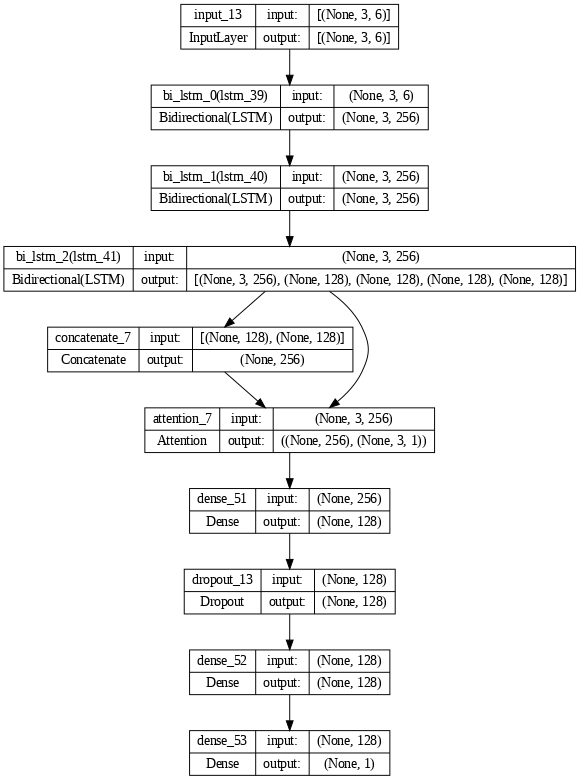

In [ ]:
keras.utils.plot_model(model, show_shapes=True, dpi = 70)

In [ ]:
model.compile(loss='mse', optimizer='adam',metrics=['mae', 'mape'])


In [ ]:
X_train.shape

(1150, 3, 6)

In [ ]:
y_train.shape

(1150, 1)

In [ ]:
X_test.shape

(286, 3, 6)

In [ ]:
tf.config.run_functions_eagerly(True)
BATCH_SIZE = 128
EPOCHS =100
history = model.fit(X_train,y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.3)

Epoch 1/100
7/7 [==============================] - 8s 1s/step - loss: 0.0690 - mae: 0.2182 - mape: 29257.1523 - val_loss: 0.0516 - val_mae: 0.2063 - val_mape: 111.5763
Epoch 2/100
7/7 [==============================] - 7s 1s/step - loss: 0.0323 - mae: 0.1432 - mape: 512398.7188 - val_loss: 0.0162 - val_mae: 0.0997 - val_mape: 37.8520
Epoch 3/100
7/7 [==============================] - 5s 781ms/step - loss: 0.0248 - mae: 0.1200 - mape: 234874.7656 - val_loss: 0.0106 - val_mae: 0.0841 - val_mape: 46.2541
Epoch 4/100
7/7 [==============================] - 6s 907ms/step - loss: 0.0201 - mae: 0.1121 - mape: 364639.4688 - val_loss: 0.0104 - val_mae: 0.0846 - val_mape: 47.7066
Epoch 5/100
7/7 [==============================] - 5s 669ms/step - loss: 0.0173 - mae: 0.0999 - mape: 224003.4688 - val_loss: 0.0074 - val_mae: 0.0688 - val_mape: 33.0864
Epoch 6/100
7/7 [==============================] - 5s 676ms/step - loss: 0.0148 - mae: 0.0923 - mape: 207750.1094 - val_loss: 0.0077 - val_mae: 0.0732 

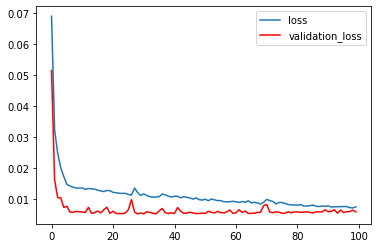

In [ ]:
plt.plot(history.history['loss'] , label='train')
plt.plot(history.history['val_loss'], label='validation',color='red')
plt.legend(['loss', 'validation_loss'], loc='upper right')
plt.show()

In [ ]:
y_pred = model.predict(X_test)
print('y_train=',y_train)
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1,-1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1,-1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred.reshape(1,-1))
print(y_test.shape)
print(y_pred.shape)
testScore = math.sqrt(mean_squared_error(y_test, y_pred))
MAPE=mean_absolute_percentage_error(y_test, y_pred)
MAE =mean_absolute_error(y_test, y_pred)
print('********  BI_LSTM_Attention ************' )
print('Test Score: %.2f RMSE' % (testScore))
print('Test Score: %.2f MAPE' % (MAPE))
print('Test Score: %.2f MAE' % (MAE))

/usr/local/lib/python3.9/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


9/9 [==============================] - 2s 191ms/step
y_train= [[0.99999994]
 [0.5084389 ]
 [0.55113274]
 ...
 [0.51556367]
 [0.47990084]
 [0.37509328]]
(282, 1)
(282, 1)
********  BI_LSTM_Attention ************
Test Score: 0.08 RMSE
Test Score: 0.22 MAPE
Test Score: 0.05 MAE


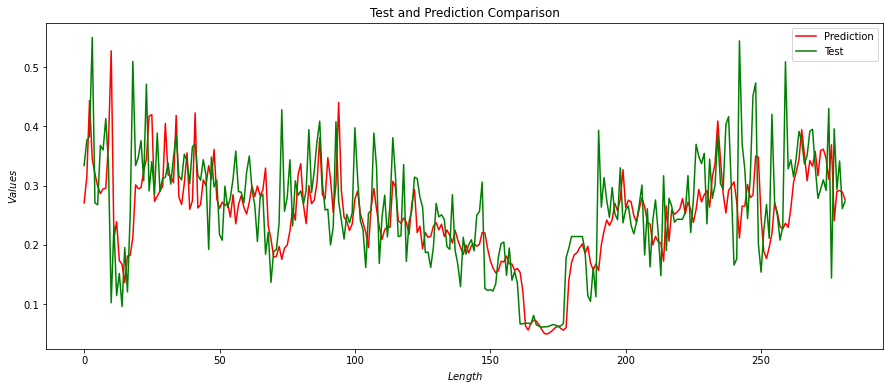

[[1761.156   1953.572   1983.728   2740.3137  1474.036   1461.28
  1914.278   1880.204   2120.156   1765.056    711.666   1298.728
   766.906    935.834    682.88    1133.726    794.712   1372.472
  2557.098   1760.112   1822.632   1951.09    1645.424   2383.01
  1566.714   1791.85    1542.65    2009.13    1562.682   1663.384
  1670.584   1781.146   1618.59    1822.162   1994.7521  1679.884
  1651.2839  1847.97    1798.214   1622.7379  1906.454   1923.802
  1687.44    1648.622   1805.278   1690.388   1118.82    1825.852
  1596.982   1649.22    1233.35    1190.208   1603.334   1439.426
  1512.704   1660.364   1872.178   1562.062   1557.7122  1476.106
  1708.594   1833.628   1579.914   1460.904   1180.5359  1518.418
  1542.742   1082.716   1250.9398   867.8579  1103.724   1118.6279
  1320.158   2187.91    1411.302   1516.96    1805.308   1299.25
  1644.004   1533.422   1566.51    1467.892   1571.368   2035.4178
  1554.93    1722.146   1944.772   2100.426   1628.182   1421.184
  1426.752 

In [ ]:
ax=plt.figure(figsize=(15,6))
plt.ylabel('$Values$')
plt.xlabel('$Length$')
plt.title("Test and Prediction Comparison")
plt.plot(y_pred , label='pred',color='red')
plt.plot(y_test , label='Test',color='green')
plt.legend(['Prediction', 'Test'], loc='upper right')
plt.show()

print(y_test_inv)

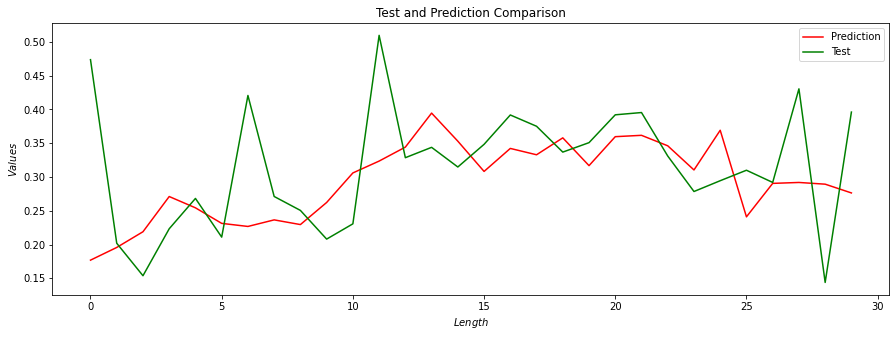

In [ ]:
MonthRealData=y_test[252:282]
MonthPrediction=y_pred[252:282]
ax=plt.figure(figsize=(15,5))
plt.ylabel('$Values$')
plt.xlabel('$Length$')
plt.title("Test and Prediction Comparison")
plt.plot(MonthPrediction , label='pred',color='red')
plt.plot(MonthRealData , label='pred',color='green')
plt.legend(['Prediction', 'Test'], loc='upper right')
plt.show()